In [1]:
import copy
import japanize_matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy
from matplotlib.pyplot import imshow
from numpy.random import randn
from scipy import stats


# 問題70

In [2]:
import copy as c

In [3]:
def inner_prod(x, y):
    return np.dot(x, y)

In [4]:
def soft_th(lambd, x):
    return np.sign(x) * np.maximum(np.abs(x) - lambd, 0)

In [5]:
def graph_lasso(s, lambd=0):
    s = np.array(s)
    W = s
    p = s.shape[1]
    beta = np.zeros((p-1, p))
    w = s.shape[0]
    beta_out = beta
    eps_out = 1
    while eps_out > 0.01:
        for j in range(p):
            a = np.delete(np.delete(W, j, 0), j, 1)
            b = np.delete(s, j, 0)[:, j]
            beta_in = beta[:, j]
            eps_in = 1
            while eps_in > 0.01:
                for h in range(p - 1):
                    cc = b[h] - inner_prod(np.delete(a, h, 1)[h, :],
                                           np.delete(beta, h, 0)[:, j])
                    beta[h, j] = soft_th(lambd, cc) / a[h, h]
                eps_in = np.max(beta[:, j] - beta_in)
                beta_in = beta[:, j]
            m = list(np.arange(j))
            n = list(np.arange(j+1, w))
            z = m + n
            W[z, j] = np.dot(a, beta[:, j])
        eps_out = np.max(beta - beta_out)
        beta_out = beta
    theta = np.zeros((p, p))
    for j in range(p - 1):
        m1 = list(np.arange(j))
        n1 = list(np.arange(j+1, p))
        z1 = m1 + n1
        theta[j, j] = 1 / (W[j, j] - np.dot(np.delete(W, j, 1)[j, :],
                                            beta[:, j]))
        theta[z1, j] = -beta[:, j] * theta[j, j]
    return theta

In [6]:
Theta = np.array([2,  0.6,    0,    0,  0.5,  0.6,    2, -0.4,  0.3,    0,
                  0, -0.4,    2, -0.2,    0,    0,  0.3, -0.2,    2, -0.2,
                  0.5,    0,    0, -0.2,    2]).reshape(-1, 5)
Sigma = np.linalg.inv(Theta)
meanvec = np.repeat(0, 5)
dat = np.random.multivariate_normal(meanvec, Sigma, 20)
# 平均meanvec，共分散行列Sigma，サンプル数no.row，変数の個数dからサンプル行列を生成
s = np.dot(dat.T, dat) / dat.shape[0]

In [7]:
print(Theta)
print(graph_lasso(s))
print(graph_lasso(s, lambd=0.01))

[[ 2.   0.6  0.   0.   0.5]
 [ 0.6  2.  -0.4  0.3  0. ]
 [ 0.  -0.4  2.  -0.2  0. ]
 [ 0.   0.3 -0.2  2.  -0.2]
 [ 0.5  0.   0.  -0.2  2. ]]
[[ 2.49030336e+00  2.31266135e-01  2.92989393e-01  4.31530648e-01
   0.00000000e+00]
 [ 3.26300254e-01  2.70086826e+00 -6.53189168e-01 -5.82484120e-02
   0.00000000e+00]
 [ 2.86984919e-01 -5.42203437e-01  1.70323069e+00 -2.47946109e-01
   0.00000000e+00]
 [ 5.12729029e-01  8.70570857e-02 -3.32300956e-01  2.04608497e+00
   0.00000000e+00]
 [ 1.38741564e+00  4.41303781e-01 -3.95649827e-01  1.11705282e-03
   0.00000000e+00]]
[[ 2.38326337  0.18557704  0.25845698  0.393501    0.        ]
 [ 0.25401309  2.66438326 -0.60625839 -0.02438585  0.        ]
 [ 0.25577991 -0.51572329  1.65630586 -0.24139217  0.        ]
 [ 0.4546619   0.01448439 -0.29351684  2.01867872  0.        ]
 [ 1.28513416  0.35061745 -0.36059549 -0.          0.        ]]


# 問題71

In [8]:
import pandas as pd
from sklearn.covariance import graphical_lasso

In [9]:
def adj(mat):
    p = mat.shape[1]
    ad = np.zeros((p, p))
    for i in range(p - 1):
        for j in range((i + 1), p):
            if mat[i, j] == 0:
                ad[i, j] = 0
            else:
                ad[i, j] = 1
    g = igraph.Graph.Adjacency(ad.tolist(), mode=igraph.ADJ_MAX)
    g.vs["label"] = list(range(g.vcount()))
    return igraph.plot(g, bbox=(300, 300))

In [10]:
df = pd.read_csv("../data/breastcancer.csv")
df.drop(df.columns[len(df.columns) - 1], axis=1, inplace=True)
df = df.values

In [11]:
w = np.zeros((250, 1000))
for i in range(1000):
    w[:, i] = df[:, i]
x = w
s = np.dot(x.T, x) / 250
fit = graphical_lasso(s, 0.75)
print(np.sum(list(map(lambda x: x == 0, fit[1]))))
y = pd.DataFrame(columns=["y"])
z = pd.DataFrame(columns=["z"])
for i in range(999):
    for j in range((i + 1), 1000):
        if fit[1][i, j] != 0:
            y = y.append(pd.DataFrame({"y": [i]}))
            z = z.append(pd.DataFrame({"z": [j]}))
y.index = np.arange(1, len(y) + 1)
z.index = np.arange(1, len(z) + 1)
edges = pd.concat([y, z], axis=1)
edges.to_csv("edges.csv")

993766


# 問題72

In [12]:
from IPython.core.display import display, SVG
import igraph
import pandas as pd
from sklearn.linear_model import ElasticNet

In [13]:
df = pd.read_csv("../data/breastcancer.csv")
df.drop(df.columns[len(df.columns) - 1], axis=1, inplace=True)
df = df.values

In [14]:
n = 250
p = 50
w = np.zeros((n, p))
for i in range(p):
    w[:, i] = df[:, i]
x = w[:, range(p)]
lambd = 0.1
model = list()
for j in range(p):
    m2 = list(np.arange(j))
    n2 = list(np.arange(j + 1, p))
    z2 = m2 + n2
    model.append(
        ElasticNet(alpha=lambd, l1_ratio=1).fit(X=x[:, z2], y=x[:, j]))
ad = np.zeros((p, p))
for i in range(p):
    for j in range(p - 1):
        k = j
        if j >= i:
            k = j + 1
        if model[i].coef_[j] != 0:
            ad[i, k] = 1
        else:
            ad[i, k] = 0

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 19, 19, 19, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 27, 27, 27, 27, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 30, 30, 31, 31, 32, 32, 33, 33, 33, 34, 34, 35, 35, 35, 36, 36, 36, 37, 37, 37, 37, 37, 39, 39, 41, 41, 42, 42, 42, 43, 43, 44, 44, 46, 46, 46, 48]
[1, 11, 12, 17, 21, 22, 23, 27, 40, 45, 47, 49, 3, 4, 9, 15, 17, 20, 22, 25, 26, 33, 36, 42, 8, 9, 14, 18, 19, 20, 23, 

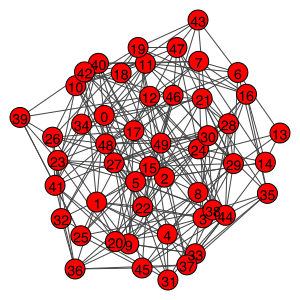

In [15]:
# ANDの場合
for i in range(p - 1):
    for j in range(i + 1, p):
        if ad[i, j] != ad[i, j]:
            ad[i, j] = 0
            ad[j, i] = 0
u = list()
v = list()
for i in range(p - 1):
    for j in range(i + 1, p):
        if ad[i, j] == 1:
            u.append(i)
            v.append(j)
print(u)
print(v)
print(ad)
adj(ad)

[[0. 1. 0. ... 1. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [1. 0. 1. ... 0. 1. 0.]]


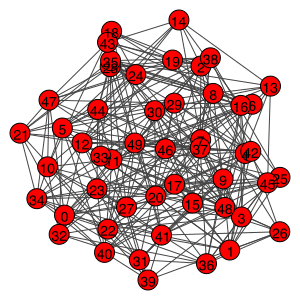

In [16]:
# ORの場合
for i in range(p - 1):
    for j in range(i + 1, p):
        if ad[i, j] != ad[j, i]:
            ad[i, j] = 1
            ad[j, i] = 1
print(ad)
adj(ad)

In [17]:
from sklearn.linear_model import LogisticRegression
import scipy.stats as ss

[[0.         0.         0.         0.03116381 0.         0.
  0.         0.         0.         0.         0.03746635 0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.03079752 0.         0.
  0.05845825 0.00054771 0.         0.         0.         0.
  0.         0.         0.14074286 0.13823256 0.         0.
  0.         0.06907584 0.         0.15844772 0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
210.0


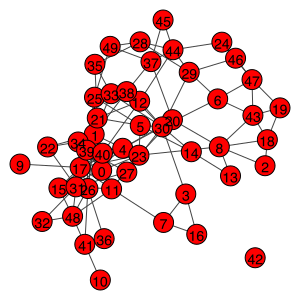

In [18]:
w = np.zeros((250, 1000))
for i in range(1000):
    w[:, i] = df[:, i]
w = (np.sign(w) + 1) / 2
p = 50
x = w[:, range(p)]
lambd = 0.15
x[x == 0] = -1
model = list()
for j in range(p):
    m3 = list(np.arange(j))
    n3 = list(np.arange(j+1, p))
    z3 = m3 + n3
    model.append(
        LogisticRegression(C=(1/(250*lambd)), penalty="l1", solver="liblinear",
                           fit_intercept=True).fit(X=x[:, z3], y=x[:, j])
    )
print(model[1].coef_)
ad = np.zeros((p, p))
for i in range(p):
    for j in range(p - 1):
        k = j
        if j >= i:
            k = j + 1
        if model[i].coef_[:, j] != 0:
            ad[i, k] = 1
        else:
            ad[i, k] = 0
for i in range(p - 1):
    for j in range(i + 1, p):
        if ad[i, j] != ad[i, j]:
            ad[i, j] = 0
            ad[j, i] = 0
print(ad)
print(np.sum(ad))
adj(ad)

離散変数と連続変数が混在しているような状況では，
- 離散変数をone-hotエンコーディングして連続変数としてみなして回帰によって処理する方法
- 上の問題のように連続変数を1 + sign(x)として0,1の離散値にしてロジスティック回帰で処理する方法  

などが考えられる．

# 問題74

In [19]:
# 第4章のfused_dual, fused_primeを用いる
def fused_2(y, D, lam_0):
    beta, lam = fused_prime(y, D)
    m, p = D.shape
    i = 0
    for k in range(1, m):
        if lam[k-1] < lam_0 <= lam[k]:
            i = k
    if lam_0 > lam[m-1]:
        beta_0 = beta[m-1, ]
    elif i == 0:
        beta_0 = beta[0, ]
    else:
        beta_0 = (beta[i-1, ] + (lam_0 - lam[i-1]) / (lam[i] - lam[i-1])
                  * (beta[i, ] - beta[i-1, ]))
    return beta_0

In [20]:
# 大きさが3以上でないとfused_2は稼働しない
def b_fused(y, lambd):
    if y[0] > y[1] + 2 * lambd:
        a = y[0] - lambd
        b = y[1] + lambd
    elif y[0] < y[1] - 2 * lambd:
        a = y[0] + lambd
        b = y[1] - lambd
    else:
        a = (y[0] + y[1]) / 2
        b = a
    return [a, b]

In [21]:
# 隣接項だけではなく，離接するすべての値と比較するFused Lasso
def graph_fused(y=[], lambd1=None, lambd2=None):
    K = len(y)
    if K == 1:
        theta = y
    elif K == 2:
        theta = b_fused(y, lambd2)
    else:
        y = np.array(y)
        L = K * (K - 1) / 2
        D = np.zeros((int(L), K))
        k = 0
        for i in range(K - 1):
            for j in range(i + 1, K):
                D[k, i] = 1
                D[k, j] = -1
                k = k + 1
        theta = fused_2(y, D, lambd2)
    theta = soft_th(lambd1, theta)
    return theta

In [22]:
# Joint Graphical Lasso
def jgl(X, lambd1, lambd2):
    K = len(X)
    p = np.array(X[1]).shape[1]
    n = np.zeros(K)
    S = list()
    for k in range(K):
        n[k] = X[k].shape[0]
        S.append(np.dot(X[k].T, X[k]) / n[k])
    rho = 1
    lambd1 = lambd1 / rho
    lambd2 = lambd2 / rho
    Theta = [0] * K
    for k in range(K):
        Theta[k] = np.diag([1] * p)
    Theta_old = [0] * K
    for k in range(K):
        Theta_old[k] = np.diag(np.random.normal(size=p))
    U = [0] * K
    for k in range(K):
        U[k] = np.zeros((p, p))
    Z = [0] * K
    for k in range(K):
        Z[k] = np.zeros((p, p))
    epsilon = 0
    epsilon_old = 1
    h = 0
    while np.abs(epsilon - epsilon_old) > 0.0001 * epsilon_old:
        h = h + 1
        Theta_old = c.deepcopy(Theta)
        epsilon_old = epsilon
        # (a)に関する更新
        for k in range(K):
            mat = S[k] - rho * Z[k] / n[k] + rho * U[k] / n[k]
            u, s, v = np.linalg.svd(mat)
            DD = (n[k] / (2 * rho)
                  * (-s + np.sqrt(np.square(s) + 4 * rho / n[k])))
            Theta[k] = np.dot(np.dot(v.T, np.diag(DD)), v)
        # (b)に関する更新
        for i in range(p):
            for j in range(p):
                A = list()
                for k in range(K):
                    A.append(Theta[k][i, j] + U[k][i, j])
                if i == j:
                    B = graph_fused(A, 0, lambd2)
                else:
                    B = graph_fused(A, lambd1, lambd2)
                for k in range(K):
                    Z[k][i, j] = B[k]
        # (c)に関する更新
        for k in range(K):
            U[k] = U[k] + Theta[k] - Z[k]
        # 収束したかどうかの検査
        epsilon = 0
        for k in range(K):
            epsilon_new = np.max(np.abs(Theta[k] - Theta_old[k]))
            if epsilon_new > epsilon:
                epsilon = epsilon_new
    print("epsilon:", epsilon)
    print("M:", np.abs(epsilon - epsilon_old))
    print("epsilon_old * 0.0001:", epsilon_old * 0.0001)
    print("The number of while loop:", h)
    return Z

epsilon: 2.6645352591003757e-15
M: 0.0
epsilon_old * 0.0001: 2.664535259100376e-19
The number of while loop: 1933
[[ 1.23240498e+00  2.37097330e-02  5.12100816e-02  1.51485772e-01
  -0.00000000e+00  0.00000000e+00  2.94677180e-01  4.64042026e-02
  -0.00000000e+00  2.68573024e-01]
 [ 2.37097330e-02  1.18452844e+00  0.00000000e+00 -5.48693714e-02
  -2.05031808e-01 -6.96669149e-02  0.00000000e+00  1.21983263e-01
   0.00000000e+00 -6.84470382e-02]
 [ 5.12100816e-02  0.00000000e+00  7.93362194e-01 -0.00000000e+00
  -2.97945887e-02  1.68321099e-01 -0.00000000e+00  1.16825607e-01
   1.42571698e-01 -0.00000000e+00]
 [ 1.51485772e-01 -5.48693714e-02 -0.00000000e+00  1.05465570e+00
   5.31992265e-02  0.00000000e+00 -6.68383963e-02  0.00000000e+00
  -1.20620038e-01 -7.77344130e-02]
 [-0.00000000e+00 -2.05031808e-01 -2.97945887e-02  5.31992265e-02
   1.16352195e+00 -0.00000000e+00 -6.10129943e-04 -6.58573627e-02
   0.00000000e+00  1.73347208e-02]
 [ 0.00000000e+00 -6.96669149e-02  1.68321099e-01  

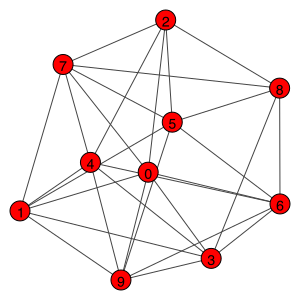

In [23]:
p = 10
K = 2
N = 100
n = np.zeros(K)
X = list()
for k in range(K):
    n[k] = N / K
    X.append(np.random.normal(size=(int(n[k]), p)))
for k in range(1, K-1):
    X[k] = X[k - 1] + np.random.normal(size=(int(n[k]), p)) * 0.1
Theta = jgl(X, 3, 0.01)
print(Theta[0])
adj(Theta[0])

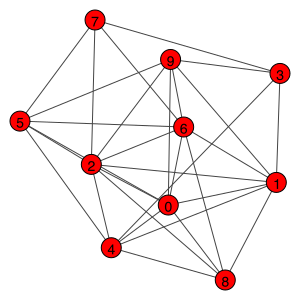

In [24]:
adj(Theta[1])

# 問題75

グループLassoでJoint Graphical Lassoを行う．

In [25]:
# Joint Graphical Lasso
def jgl(X, lambd1, lambd2):
    K = len(X)
    p = np.array(X[1]).shape[1]
    n = np.zeros(K)
    S = list()
    for k in range(K):
        n[k] = X[k].shape[0]
        S.append(np.dot(X[k].T, X[k]) / n[k])
    rho = 1
    lambd1 = lambd1 / rho
    lambd2 = lambd2 / rho
    Theta = [0] * K
    for k in range(K):
        Theta[k] = np.diag([1] * p)
    Theta_old = [0] * K
    for k in range(K):
        Theta_old[k] = np.diag(np.random.normal(size=p))
    U = [0] * K
    for k in range(K):
        U[k] = np.zeros((p, p))
    Z = [0] * K
    for k in range(K):
        Z[k] = np.zeros((p, p))
    epsilon = 0
    epsilon_old = 1
    h = 0
    while np.abs(epsilon - epsilon_old) > 0.0001 * epsilon_old:
        h = h + 1
        Theta_old = c.deepcopy(Theta)
        epsilon_old = epsilon
        # (a)に関する更新
        for k in range(K):
            mat = S[k] - rho * Z[k] / n[k] + rho * U[k] / n[k]
            u, s, v = np.linalg.svd(mat)

                

            DD = (n[k] / (2 * rho)
                  * (-s + np.sqrt(np.square(s) + 4 * rho / n[k])))
            Theta[k] = np.dot(np.dot(v.T, np.diag(DD)), v)
        # (b)に関する更新
        for i in range(p):
            for j in range(p):
                A = list()
                for k in range(K):
                    A.append(Theta[k][i, j] + U[k][i, j])
                if i == j:
                    B = A
                else:
                    B = soft_th(lambd1 / rho, A) * np.max(
                        1 - lambd2 / rho / np.sqrt(1e-5 + np.linalg.norm(soft_th(lambd1 / rho, A), 2) ** 2), 0)
                for k in range(K):
                    Z[k][i, j] = B[k]
        # (c)に関する更新
        for k in range(K):
            U[k] = U[k] + Theta[k] - Z[k]
        # 収束したかどうかの検査
        epsilon = 0
        for k in range(K):
            epsilon_new = np.max(np.abs(Theta[k] - Theta_old[k]))
            if epsilon_new > epsilon:
                epsilon = epsilon_new
    print("epsilon:", epsilon)
    print("M:", np.abs(epsilon - epsilon_old))
    print("epsilon_old * 0.0001:", epsilon_old * 0.0001)
    print("The number of while loop:", h)
    return Z

epsilon: 3.885780586188048e-15
M: 0.0
epsilon_old * 0.0001: 3.885780586188048e-19
The number of while loop: 2199
[[ 1.32947699e+00  9.77973442e-02 -0.00000000e+00  1.98625838e-04
   0.00000000e+00  0.00000000e+00 -1.06142841e-01  0.00000000e+00
  -2.11920364e-01  4.64186227e-02]
 [ 9.77973442e-02  9.61735134e-01 -1.21755144e-02 -0.00000000e+00
  -2.98562901e-01  0.00000000e+00  0.00000000e+00 -1.28866744e-02
   0.00000000e+00 -2.52438638e-02]
 [-0.00000000e+00 -1.21755144e-02  1.11815596e+00  4.24226466e-02
   7.83826215e-02 -2.62900586e-03  8.21442561e-02  1.93535247e-01
   4.91461943e-02 -0.00000000e+00]
 [ 1.98625838e-04 -0.00000000e+00  4.24226466e-02  1.06874906e+00
   1.95421198e-01 -6.00037609e-02 -0.00000000e+00  0.00000000e+00
   0.00000000e+00 -1.67719875e-01]
 [ 0.00000000e+00 -2.98562901e-01  7.83826215e-02  1.95421198e-01
   7.94835241e-01 -7.20757495e-02 -2.88499836e-02 -6.85042420e-02
   4.65347426e-02 -5.66731939e-02]
 [ 0.00000000e+00  0.00000000e+00 -2.62900586e-03 -6

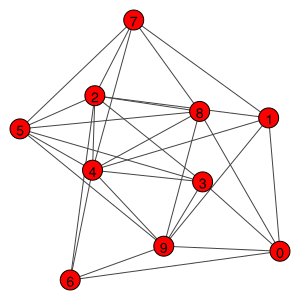

In [26]:
p = 10
K = 2
N = 100
n = np.zeros(K)
X = list()
for k in range(K):
    n[k] = N / K
    X.append(np.random.normal(size=(int(n[k]), p)))
for k in range(1, K-1):
    X[k] = X[k - 1] + np.random.normal(size=(int(n[k]), p)) * 0.1
Theta = jgl(X, 3, 0.01)
print(Theta[0])
adj(Theta[0])


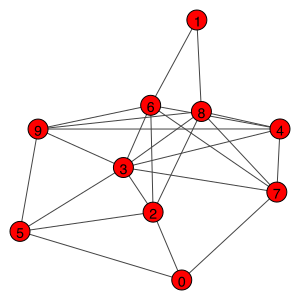

In [27]:
adj(Theta[1])